In [ ]:
import re
import json
import json_repair
import pandas as pd
import pickle as pkl

from pathlib import Path
from pdb import set_trace
import numpy as np
import matplotlib.pyplot as plt


In [8]:
data_path = Path("../data/raw/framing_results/")  
processed_path = Path("../data/processed/")  

In [5]:
def get_valid_json_list(data):
    out_list = []
    for i, out in enumerate(data):
        try:
            # Check if json is already valid within brackets
            basic_fix_str = out[out.index("{"):out.rindex("}")+1]
            basic_fix_str = basic_fix_str.replace("\n","")
            json_obj = json.loads(basic_fix_str)
            assert type(json_obj) == dict
            assert len(json_obj) == 2
        except:
            # Fix json
            try:
                json_obj = json_repair.loads(out)
                assert len(json_obj) == 2
                assert type(json_obj) == dict
            except:
                out_list.append({"error": "json_out_dict error"})
                continue
        assert type(json_obj) == dict
        out_list.append(json_obj)
    return out_list

In [7]:
data_lists = {"US":[], "UK":[], "ME":[]}
for region, data_list in data_lists.items():
    for i in range(1,len([*data_path.glob(f"{region}*")])):
        data_lists[region].extend(get_valid_json_list(pkl.load(open(data_path/f"{region}_{i}.pkl", "rb"))))

In [11]:
data_dfs = {}
for region, data_list in data_lists.items():
    region_list = []
    for i, json_out in enumerate(data_list):
        json_out_list = list(json_out.values())
        try:
            json_out_dict = json_out_list[0] | json_out_list[1]
            assert len(json_out_dict) == len(json_out_list[0])+len(json_out_list[1])
            json_out_dict["index"] = i
        except:
            continue
        region_list.append(json_out_dict)
    region_df = pd.DataFrame(region_list)
    valid_columns = []
    df_len = len(region_df)
    for col_name,col in region_df.items():
        if col.isna().sum() > 0.5*df_len:
            continue
        else:
            valid_columns.append(col_name)
    region_df = region_df[valid_columns]
    region_df.reset_index()
    region_df = region_df.rename(columns={"index": "index"})
    region_df = region_df.set_index("index")
    if region == "ME":
        orig_df = pd.read_csv("../data/raw/framing_results/selected_MiddleEast.csv")
    else:
        orig_df = pd.read_csv(f"../data/raw/framing_results/selected_{region}.csv")
    orig_df = orig_df.loc[region_df.index]
    merged_df = pd.concat([orig_df, region_df], axis=1)

    data_dfs[region] = merged_df
    data_dfs[region].to_csv(processed_path/f"{region}_framing.csv", index=False)

### War journalism indicators

In [101]:
def recursive_count(data):
    if isinstance(data, list):
        # Check if list is empty
        if not data:
            return 0
        if isinstance(data[0], str):
            return 1
        elif isinstance(data[0], list):
            return len(data)
        else:
            print(f"Unknown data type in list: {type(data[0])}")
            return 0
    # If dict, recursively count the values
    elif isinstance(data, dict):
        count = 0
        for _, value in data.items():
            sub_value = recursive_count(value)
            count += sub_value
        return count
    # Hacky fix for the case when the data is a pandas Series
    elif isinstance(data, pd.Series):
        value = data.values[1]
        return recursive_count(value)
    elif pd.isna(data):
        return 0
    elif isinstance(data, str):
        return 1
    else:
        print(f"Unknown data type: {type(data)}")
    return 0
        
def flatten_and_count(df):
    result_list = []
    result_count_list = []
    for _, row in df.iterrows():
        result = {}
        for col_name, col_value in dict(row).items():
            result[col_name] = recursive_count(col_value)
        result_list.append(result)
        result_count = sum(result.values())
        result_count_list.append(result_count)
    return result_list, result_count_list

Unknown data type in list: <class 'NoneType'>


/var/folders/v4/1f9w3z693hv5dk6wxj46w3y80000gn/T/ipykernel_76743/2393046173.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  war_indicators['indicators_flattened'] = war_indicator_list
/var/folders/v4/1f9w3z693hv5dk6wxj46w3y80000gn/T/ipykernel_76743/2393046173.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  war_indicators['indicators_count'] = war_indicator_count
/var/folders/v4/1f9w3z693hv5dk6wxj46w3y80000gn/T/ipykernel_76743/2393046173.py:17: SettingWithCopyWarning: 
A value is trying to be set o

Unknown data type in list: <class 'NoneType'>
Unknown data type in list: <class 'NoneType'>
Unknown data type in list: <class 'NoneType'>
Unknown data type in list: <class 'NoneType'>
Unknown data type in list: <class 'NoneType'>
Unknown data type in list: <class 'NoneType'>
Unknown data type in list: <class 'NoneType'>
Unknown data type in list: <class 'NoneType'>
Unknown data type in list: <class 'dict'>
Unknown data type in list: <class 'NoneType'>
Unknown data type in list: <class 'NoneType'>
Unknown data type in list: <class 'NoneType'>
Unknown data type in list: <class 'NoneType'>
Unknown data type in list: <class 'NoneType'>
Unknown data type in list: <class 'NoneType'>
Unknown data type in list: <class 'NoneType'>
Unknown data type in list: <class 'dict'>
Unknown data type in list: <class 'dict'>
Unknown data type in list: <class 'dict'>
Unknown data type in list: <class 'NoneType'>
Unknown data type in list: <class 'NoneType'>
Unknown data type in list: <class 'NoneType'>
Unkn

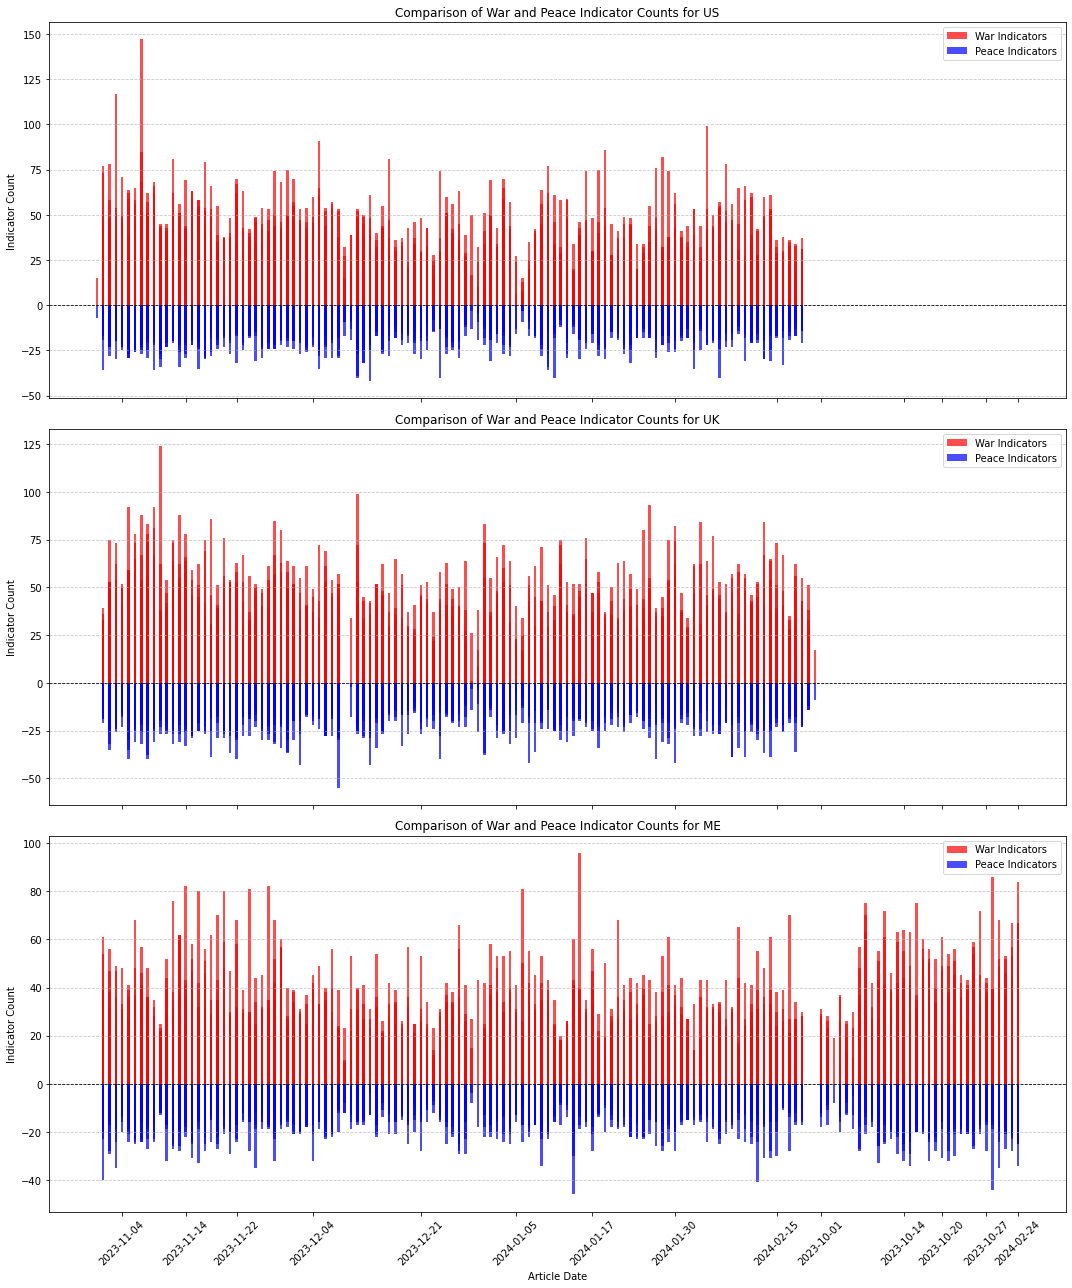

In [118]:
fig, axes = plt.subplots(3, 1, figsize=(15, 18), sharex=True)
width = 0.4  # Width of the bars

for i, region in enumerate(["US", "UK", "ME"]):
    # Select relevant columns for war and peace indicators
    war_indicators = data_dfs[region][['adversarial_frame',
        'focus_on_elites', 'labelling_of_people', 'language',
        'partisan_framing', 'focus_on_visible_effects_of_war',
        'nationalistic_frame', 'military_solution']]
    peace_indicators = data_dfs[region][['peace_frame', 'focus_on_invisible_effects_of_war', 'people_orientation', 'victim_orientation']]

    # Flatten and count the indicators
    war_indicator_list, war_indicator_count = flatten_and_count(war_indicators)
    war_indicators['indicators_flattened'] = war_indicator_list
    war_indicators['indicators_count'] = war_indicator_count
    peace_indicator_list, peace_indicator_count = flatten_and_count(peace_indicators)
    peace_indicators['indicators_flattened'] = peace_indicator_list
    peace_indicators['indicators_count'] = peace_indicator_count
    war_indicators['date_publish'] = data_dfs[region]['date_publish']
    peace_indicators['date_publish'] = data_dfs[region]['date_publish']

    # Drop nans
    war_indicators = war_indicators.dropna(subset=["date_publish"])
    peace_indicators = peace_indicators.dropna(subset=["date_publish"])

    # Convert date_publish to datetime
    war_indicators['date'] = war_indicators['date_publish'].apply(lambda x: pd.to_datetime(x.split(" ")[0]))
    peace_indicators['date'] = peace_indicators['date_publish'].apply(lambda x: pd.to_datetime(x.split(" ")[0]))

    war_indicators_sorted = war_indicators.sort_values(by='date')
    peace_indicators_sorted = peace_indicators.sort_values(by='date')
    war_indicators_sorted['date'] = war_indicators_sorted['date'].dt.strftime('%Y-%m-%d')
    peace_indicators_sorted['date'] = peace_indicators_sorted['date'].dt.strftime('%Y-%m-%d')

    war_indicator_count = war_indicators_sorted['indicators_count']
    peace_indicator_count = peace_indicators_sorted['indicators_count']

    # Create a bar plot to contrast war and peace indicator counts
    indices = war_indicators_sorted['date']  # Use the 'date_publish' column for the x-axis
    axes[i].bar(indices, war_indicator_count, width, label='War Indicators', color='red', alpha=0.7)
    axes[i].bar(indices, [-count for count in peace_indicator_count], width, label='Peace Indicators', color='blue', alpha=0.7)

    # Add labels and title
    axes[i].set_ylabel('Indicator Count')
    axes[i].set_title(f'Comparison of War and Peace Indicator Counts for {region}')
    axes[i].axhline(0, color='black', linewidth=0.8, linestyle='--')  # Add a horizontal line at y=0
    axes[i].legend()
    axes[i].grid(axis='y', linestyle='--', alpha=0.7)

# Add shared x-axis label
plt.xlabel('Article Date')
plt.xticks(indices[::200], labels=indices[::200], rotation=45)  # Label every 200th date on the x-axis
plt.tight_layout()
plt.savefig("../data/figures/war_peace_indicators_region.png", dpi=300)
plt.show()



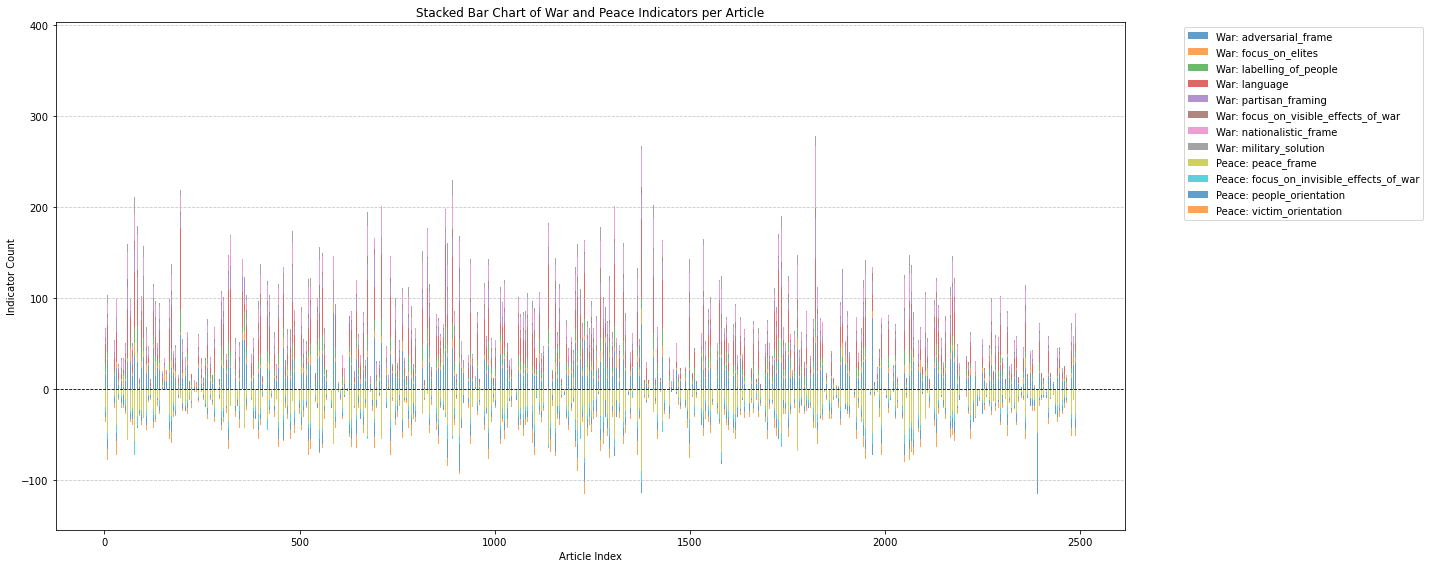

In [133]:
# Extract the keys for war and peace indicators
war_keys = list(war_indicator_list[0].keys())
peace_keys = list(peace_indicator_list[0].keys())

# Prepare data for plotting
indices = np.arange(len(war_indicator_list))  # Indices for the articles

# Initialize the figure
plt.figure(figsize=(20, 8))

# Plot war indicators as stacked bars
bottom_war = np.zeros(len(war_indicator_list))
for key in war_keys:
    values = [item[key] for item in war_indicator_list]
    plt.bar(indices, values, width, bottom=bottom_war, label=f'War: {key}', alpha=0.7)
    bottom_war += values

# Plot peace indicators as stacked bars (negative values for bottom stacking)
bottom_peace = np.zeros(len(peace_indicator_list))
for key in peace_keys:
    values = [-item[key] for item in peace_indicator_list]
    plt.bar(indices, values, width, bottom=bottom_peace, label=f'Peace: {key}', alpha=0.7)
    bottom_peace += values


# Add labels and title
plt.xlabel('Article Index')
plt.ylabel('Indicator Count')
plt.title('Stacked Bar Chart of War and Peace Indicators per Article')
plt.axhline(0, color='black', linewidth=0.8, linestyle='--')  # Add a horizontal line at y=0
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y', linestyle='--', alpha=0.7)
# Show the plot
plt.tight_layout()
plt.show()